In [84]:
import numpy as np
from scipy import linalg as la
from scipy import optimize as op
from math import log
from math import sqrt
from scipy.stats import norm
from matplotlib import pyplot as plt

### Problem 1

In [34]:
def arma_likelihood(time_series, phis=np.array([]), thetas=np.array([]), mu=0., sigma=1.):
    """
    Return the log-likelihood of the ARMA model parameters, given the time
    series.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
     The time series in question, z_t
    phis : ndarray of shape (p,)
     The phi parameters
    thetas : ndarray of shape (q,)
     The theta parameters
    mu : float
     The parameter mu
    sigma : float
     The standard deviation of the a_t random variables
    Returns
    -------
    log_likelihood : float
     The log-likelihood of the model
    """
    # Get constants
    d = time_series.ndim
    n = time_series.shape[0]
    p = phis.shape[0]
    q = thetas.shape[0]
    r = max(p,q+1)
    # Define matrices
    I = np.eye(r**2)
    F = np.diag(np.ones(r-1),-1)
    F[0,0:p] = phis
    H = np.zeros((d,r))
    H[0,0] = 1
    H[0,1:q+1] = thetas
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    # Calculate Ps and xs
    P = la.solve(I-np.kron(F,F),Q.flatten()).reshape(r,r)
    x = np.zeros(r)
    log_lik = 0
    count = 0
    for z in (time_series - mu) :
        μ = H.dot(x)
        Σ = np.dot(H.dot(P),H.T)
        log_lik += norm.logpdf(z,μ,np.sqrt(Σ))
        #if count == n-1 :
            #break
        # Update
        yk = z - H.dot(x)
        Sk = np.dot(H.dot(P),H.T)
        Kk = np.dot(P.dot(H.T),la.inv(Sk))
        x = x + Kk.dot(yk)
        P = (np.eye(r)-Kk.dot(H)).dot(P)
        # Predict
        x = F.dot(x)
        P = np.dot(F.dot(P),F.T) + Q
        count += 1
    return log_lik

In [41]:
time_series_a = np.loadtxt('time_series_a.txt')
time_series_b = np.loadtxt('time_series_b.txt')
time_series_c = np.loadtxt('time_series_c.txt')
print(arma_likelihood(time_series_a,phis=np.array([0.9]),mu=17,sigma=0.4))
print(arma_likelihood(time_series_a,phis=np.array([0.9]),thetas=np.array([0.3]),mu=17,sigma=0.4))

[[-77.60354497]]
[[-106.10634054]]


### Problem 2

In [48]:
def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    Returns
    -------
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    """
    n = time_series.shape[0]
    min_ = False
    best_params = []
    best_pq = (0,0)
    for (p,q) in list(zip([0,1,2,3],[0,1,2,3])) :
        k = p+q+2
        const = 2*k*(1+(k+1)/(n-k))
        def f(x):
            return -1*arma_likelihood(time_series, phis=x[:p], thetas=x[p:p+q], mu=x[-2],sigma=x[-1])
        x0 = np.zeros(p+q+2)
        x0[-2] = time_series.mean()
        x0[-1] = time_series.std()
        sol = op.fmin(f,x0,maxiter=10000, maxfun=10000)
        new_min = const + 2*f(sol)
        if not min_ or new_min < min_ :
            min_ = new_min
            best_params = sol
            best_p = p
            best_q = q
    result = (best_params[:best_p],best_params[best_p:best_p+best_q],best_params[-2],best_params[-1])
    return result

In [49]:
best_a = arma_fit(time_series_a)
best_b = arma_fit(time_series_b)
best_c = arma_fit(time_series_c)

Optimization terminated successfully.
         Current function value: 98.149109
         Iterations: 22
         Function evaluations: 45


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in sqrt


Optimization terminated successfully.
         Current function value: 50.745092
         Iterations: 202
         Function evaluations: 340
Optimization terminated successfully.
         Current function value: 50.608759
         Iterations: 556
         Function evaluations: 869
Optimization terminated successfully.
         Current function value: 49.959610
         Iterations: 750
         Function evaluations: 1108
Optimization terminated successfully.
         Current function value: 1251.093918
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 1249.736652
         Iterations: 101
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 1249.585056
         Iterations: 364
         Function evaluations: 566
Optimization terminated successfully.
         Current function value: 1242.383765
         Iterations: 1353
         Function evaluations: 1943
Opti

### Problem 3

In [50]:
print(f'Best values for a were: {best_a}')
print(f'Best values for b were: {best_b}')
print(f'Best values for c were: {best_c}')

Best values for a were: (array([ 0.90867024]), array([-0.57585945]), 17.065262486340927, 0.31253098628150655)
Best values for b were: (array([ 0.2350456, -0.3839864, -0.6566961]), array([-0.20234983,  0.41060419,  0.67314649]), -0.2853804404204241, 7.0334525375368138)
Best values for c were: (array([ 1.3170405 , -0.62133285]), array([ 0.27845088, -0.10615388]), 48.37931873915241, 14.593807162952444)


### Problem 4

In [91]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0., sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    future_periods : int
    The number of future periods to return
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
    The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
    The standard deviations of z for times n+1, ..., n+future_periods
    """
    # Get constants
    d = time_series.ndim
    n = time_series.shape[0]
    p = phis.shape[0]
    q = thetas.shape[0]
    r = max(p,q+1)
    # Define matrices
    I = np.eye(r**2)
    F = np.diag(np.ones(r-1),-1)
    F[0,0:p] = phis
    H = np.zeros((d,r))
    H[0,0] = 1
    H[0,1:q+1] = thetas
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    # Calculate Ps and xs
    P = la.solve(I-np.kron(F,F),Q.flatten()).reshape(r,r)
    x = np.zeros(r)
    for z in (time_series - mu) :
        μ = H.dot(x)
        Σ = np.dot(H.dot(P),H.T)
        yk = z - H.dot(x)
        Sk = np.dot(H.dot(P),H.T)
        Kk = np.dot(P.dot(H.T),la.inv(Sk))
        x = x + Kk.dot(yk)
        P = (np.eye(r)-Kk.dot(H)).dot(P)
        # Predict
        x = F.dot(x)
        P = np.dot(F.dot(P),F.T) + Q
    fut_mu = [H.dot(x)]
    fut_stds = [sqrt(np.dot(H.dot(P),H.T)[0,0])]
    for k in range(future_periods) :
        x = F.dot(x)
        P = np.dot(F.dot(P),F.T)+Q
        fut_mu.append(H.dot(x)+mu)
        fut_stds.append(sqrt(np.dot(H.dot(P),H.T)[0,0]))
    return fut_mu[1:],fut_stds[1:]

In [92]:
ax,ap = arma_forecast(time_series_a, best_a[0], best_a[1], best_a[2], best_a[3], 24)
bx,bp = arma_forecast(time_series_a, best_b[0], best_b[1], best_b[2], best_b[3], 24)
cx,cp = arma_forecast(time_series_a, best_c[0], best_c[1], best_c[2], best_c[3], 24)

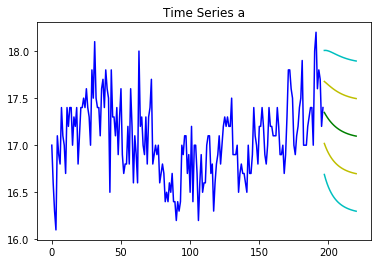

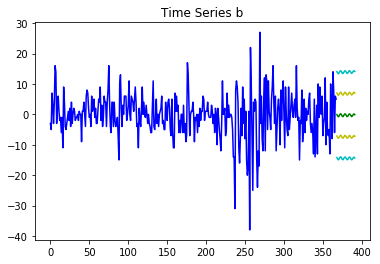

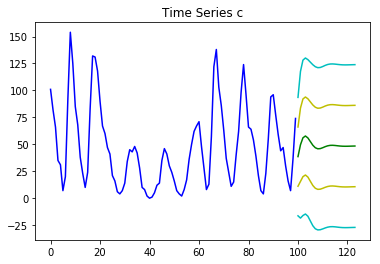

In [93]:
ax_known = np.arange(0,len(time_series_a),1)
ax_unknown = np.arange(len(time_series_a),len(time_series_a)+24,1)
bx_known = np.arange(0,len(time_series_b),1)
bx_unknown = np.arange(len(time_series_b),len(time_series_b)+24,1)
cx_known = np.arange(0,len(time_series_c),1)
cx_unknown = np.arange(len(time_series_c),len(time_series_c)+24,1)
plt.plot(ax_known,time_series_a,'b',label='Current')
plt.plot(ax_unknown,ax,'g')
plt.plot(ax_unknown,[ax[i]+ap[i] for i in range(len(ax))],'y-')
plt.plot(ax_unknown,[ax[i]-ap[i] for i in range(len(ax))],'y-')
plt.plot(ax_unknown,[ax[i]+2*ap[i] for i in range(len(ax))],'c-')
plt.plot(ax_unknown,[ax[i]-2*ap[i] for i in range(len(ax))],'c-')
plt.title('Time Series a')
plt.show()
plt.plot(bx_known,time_series_b,'b',label='Current')
plt.plot(bx_unknown,bx,'g')
plt.plot(bx_unknown,[bx[i]+bp[i] for i in range(len(bx))],'y-')
plt.plot(bx_unknown,[bx[i]-bp[i] for i in range(len(bx))],'y-')
plt.plot(bx_unknown,[bx[i]+2*bp[i] for i in range(len(bx))],'c-')
plt.plot(bx_unknown,[bx[i]-2*bp[i] for i in range(len(bx))],'c-')
plt.title('Time Series b')
plt.show()
plt.plot(cx_known,time_series_c,'b',label='Current')
plt.plot(cx_unknown,cx,'g')
plt.plot(cx_unknown,[cx[i]+cp[i] for i in range(len(cx))],'y-')
plt.plot(cx_unknown,[cx[i]-cp[i] for i in range(len(cx))],'y-')
plt.plot(cx_unknown,[cx[i]+2*cp[i] for i in range(len(cx))],'c-')
plt.plot(cx_unknown,[cx[i]-2*cp[i] for i in range(len(cx))],'c-')
plt.title('Time Series c')
plt.show()